## Python programs
I created a class object that is called a [Region](#object-orientation). This object has different variables and functions associated with it. It was designed with the objective of being able to quickly and flexibly complete the following tasks:

 - Mean monthly CG [flash density](#flash-density) for a region; [~ 1km grid](#1km-grid)
 - Mean monthly [diurnal cycle](#diurnal-cycle) of CG flash density by month for a region
 - [Largest 100](#top-100) CG flash density days (12 UTC - 12 UTC) for a region
 - [JJA time (UTC) of maximum](#peak-time) CG flash density (15 minute time resolution); ~ 1 km grid
 - [“Amplitude” of the diurnal cycle](#amplitude-of-DC); 15 minute time resolution ~1km grid.  CG flash density at the time of maximum flash density - CG flash density a time of minimum flash density divided by the mean flash density. 

In [1]:
from __init__ import *
from plotting import *
from region import Region

%matplotlib inline

If you have already install dask (in terminal: `conda install dask`) and the files are in good order, all have the same variables, and are available locally, then this will work:

    xr.open_mfdataset('/home/jsignell/erddapData/Cloud_to_Ground_Lightning/2014_01_*.nc', concat_dim='record')

If they don't have the same variables, then we can use the preprocess keyword to get just the variables that we know are in all the datasets:

    xr.open_mfdataset('/home/jsignell/erddapData/Cloud_to_Ground_Lightning/*_04_*.nc', 
                      concat_dim='record', preprocess=(lambda x: x[['strokes', 'amplitude']])

If you don't have them locally, then you can use list of OPeNDAP URLs instead of the wildcard notation.

## filter out cloud to cloud
Do we want to implement something like this? If we do, then should we just look at the new data, or should we also try to suss out which of the old data were cloud to ground vs cloud to cloud

In [9]:
ds = xr.open_mfdataset('/home/jsignell/erddapData/Cloud_to_Ground_Lightning/Cedar_City_UT/201*_08_*.nc', concat_dim='record')

In [3]:
x = ds.lon[ds.cloud_ground == 'G'].values
y = ds.lat[ds.cloud_ground == 'G'].values

## 1km grid

Once we have all the settings and imports, we should grid the data. The main thing that makes lightning different from other datasets is that it is a point process, so when we grid and aggregate we want to count strikes per grid cell rather than interpolating. This is a good [example](http://stackoverflow.com/questions/11015252/countig-points-in-boxes-of-a-grid) of how we will go about doing that. The premise is that we want to count the strikes within each bin, so we can use a 2D histogram.

In [10]:
x = ds.lon.values
y = ds.lat.values

gridx = np.linspace(x.min(), x.max(), 600)
gridy = np.linspace(y.min(), y.max(), 600)

grid, _, _ = np.histogram2d(x, y, bins=[gridx, gridy])
density = grid.T

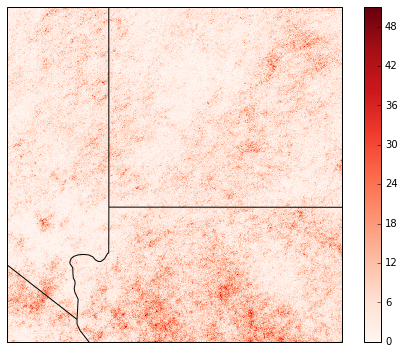

In [11]:
plt.figure(figsize=(8,6))
ax = background(plt.axes(projection=ccrs.PlateCarree()))
den = ax.pcolor(gridx, gridy, density, cmap='Reds')
plt.colorbar(den, ax=ax)

In [12]:
ds.close()

## object orientation
[Top](#Python-programs)

There are constant variables for each region so it makes sense to define a class to hold info and functions relating to the region. One way to initialize the class object is by passing a dictionary containing the lat and lon of the center of the region as well as the radius of the box that we are interested in. This class definiteion is now contained in region.py

## flash density
Before you run any more of the examples in this notebook you will need to import the Region class. 

In [20]:
from region import Region

In [18]:
c = Region(city=cities['cedar'])
c.define_grid(nbins=60)
c.show()

center: (37.590833333333336, -112.86222222222221)
radius: 3
path: /home/jsignell/erddapData/Cloud_to_Ground_Lightning/Cedar_City_UT/
subsetted: True


In [19]:
MMDC_grid = {}
MMFC_grid = {}
for m in range(1,13):
    print m
    ds = c.get_ds(m=m, grid=True)
    c.to_DC_grid(ds)
    ds.close()
    MMDC_grid.update({m: c.DC_grid})
    MMFC_grid.update({m: c.FC_grid})

1
2
3
4
5
6
7
8
9
10
11
12


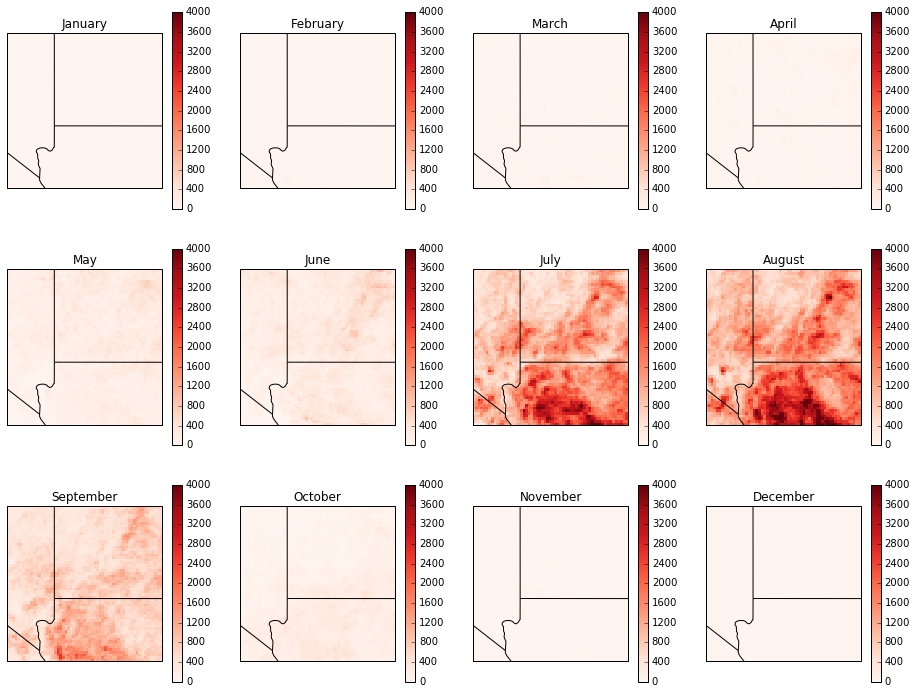

In [52]:
plt.figure(figsize=(16, 12))
for m in months.keys():
    ax = background(plt.subplot(3, 4, m, projection=ccrs.PlateCarree()))
    den = ax.pcolor(c.gridx, c.gridy, MMFC_grid[m], cmap='Reds', vmin=0, vmax=4000)
    ax.set_title(months[m])
    plt.colorbar(den, ax=ax)

## diurnal cycle

In [2]:
h = range(12,24)
h.extend(range(0,13))

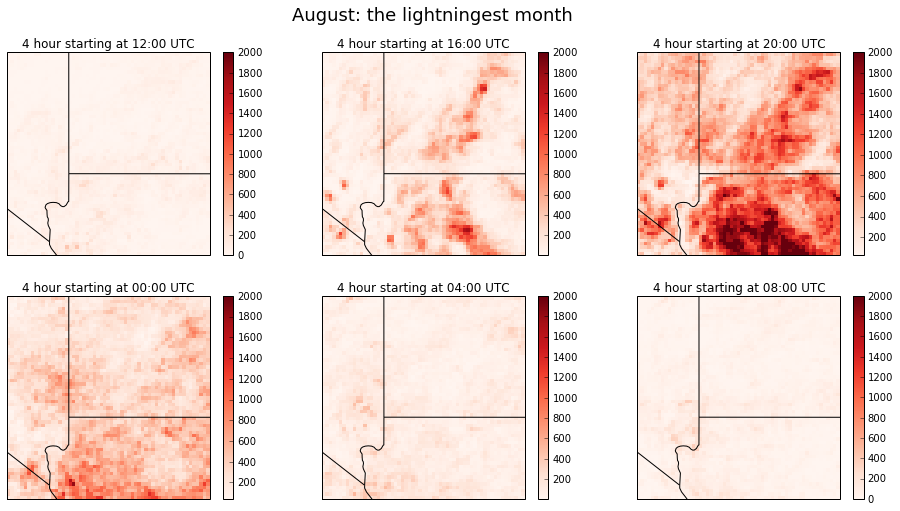

In [55]:
plt.figure(figsize=(16,8))
n=1
step = 4
for i in range(0,24,step):
    q=np.zeros(MMDC_grid[8][0].shape)
    for hr in h[i:i+step]:
        q+=MMDC_grid[8][hr]
    ax = plt.subplot(2, 3, n, projection=ccrs.PlateCarree())
    ax = background(ax)
    ax.set_title('{step} hour starting at {t:02d}:00 UTC'.format(step=step, t=h[i]))
    den = ax.pcolor(c.gridx, c.gridy, q, cmap='Reds', vmax=2000)
    plt.colorbar(den, ax=ax)
    n+=1
plt.suptitle('August: the lightningest month', fontsize=18);

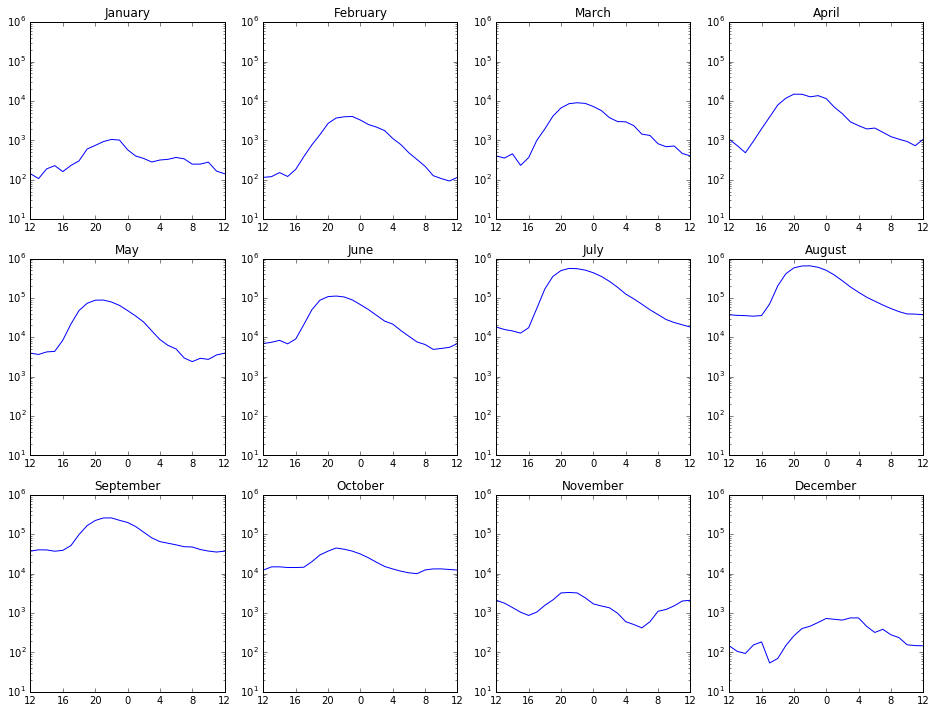

In [53]:
plt.figure(figsize=(16, 12))
for m in months.keys():
    ax = plt.subplot(3, 4, m)
    ax.plot([np.sum(MMDC_grid[m][hr]) for hr in h])
    ax.set_xticks(range(0,25,4))
    ax.set_xticklabels([h[n] for n in range(0,25,4)])
    ax.set_ylim(10**1, 10**6)
    ax.semilogy()
    ax.set_xlim(0,24)
    ax.set_title(months[m])

## peak time
[Top](#Python-programs)
 - JJA CG flash density (Hour time resolution); ~ 10 km grid


In [123]:
JJADC_grid = {}
for k,v in MMDC_grid[6].items():
    JJADC_grid.update({k: v + MMDC_grid[7][k]+MMDC_grid[8][k]})

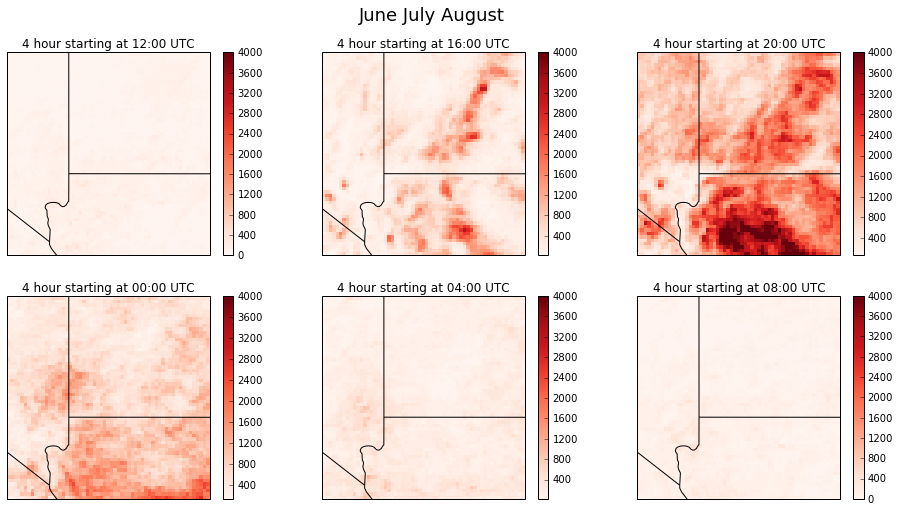

In [127]:
plt.figure(figsize=(16,8))
n=1
step = 4
for i in range(0,24,step):
    q=np.zeros(JJADC_grid[0].shape)
    for hr in h[i:i+step]:
        q+=JJADC_grid[hr]
    ax = plt.subplot(2, 3, n, projection=ccrs.PlateCarree())
    ax = background(ax)
    ax.set_title('{step} hour starting at {t:02d}:00 UTC'.format(step=step, t=h[i]))
    den = ax.pcolor(c.gridx, c.gridy, q, cmap='Reds', vmax=4000)
    plt.colorbar(den, ax=ax)
    n+=1
plt.suptitle('June July August', fontsize=18);

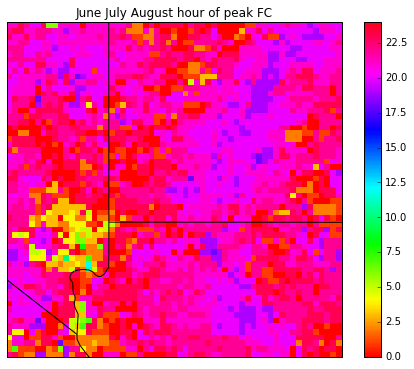

In [142]:
plt.figure(figsize=(8,6))
ax = plt.subplot(1,1, 1, projection=ccrs.PlateCarree())
ax = background(ax)

a = np.argmax(np.stack(JJADC_grid.values()), axis=0)
den = ax.pcolor(c.gridx, c.gridy, a, cmap='hsv', vmax=24)
ax.set_title('June July August hour of peak FC')
plt.colorbar(den, ax=ax);

## amplitude of DC
[Top](#Python-programs)
 - “Amplitude” of the diurnal cycle; 1 hour time resolution ~10km grid.  CG flash density at the time of maximum flash density - CG flash density a time of minimum flash density divided by the mean flash density. 

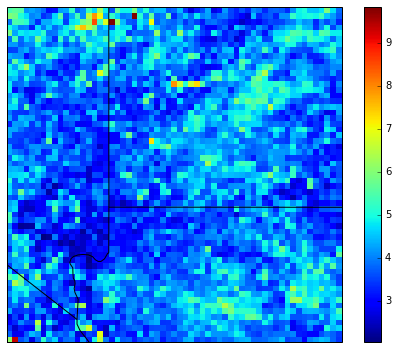

In [153]:
plt.figure(figsize=(8,6))
hourly3D = np.stack(JJADC_grid.values())
amplitude = ((np.max(hourly3D, axis=0)-np.min(hourly3D, axis=0))/np.mean(hourly3D, axis=0))
ax = background(plt.subplot(1, 1, 1, projection=ccrs.PlateCarree()))
den = ax.pcolor(c.gridx, c.gridy, amplitude)
plt.colorbar(den, ax=ax);

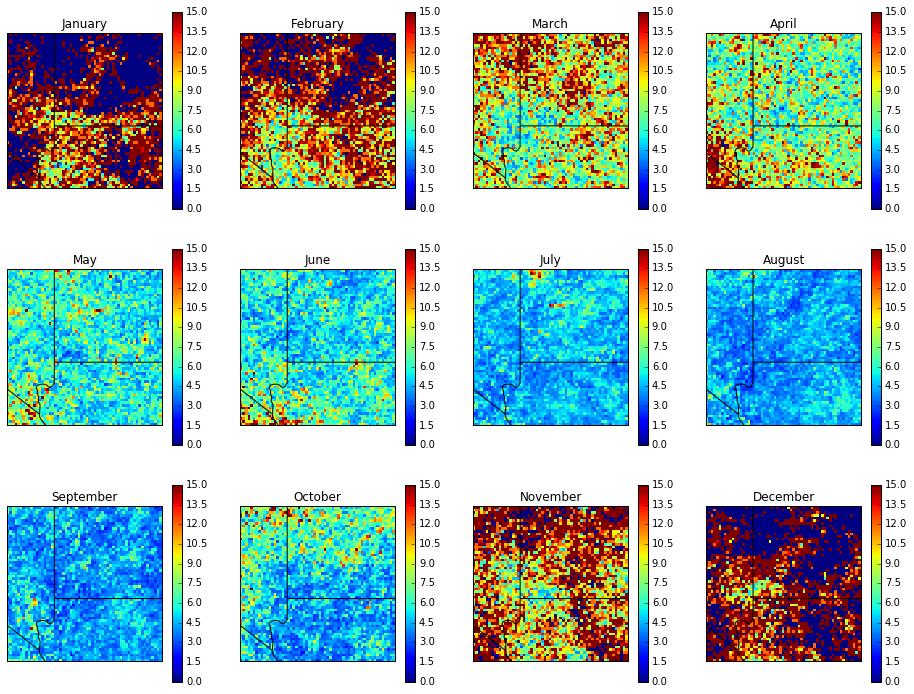

In [167]:
plt.figure(figsize=(16, 12))
for m in months.keys():
    ax = background(plt.subplot(3, 4, m, projection=ccrs.PlateCarree()))
    hourly3D = np.stack(MMDC_grid[m].values())
    amplitude = ((np.max(hourly3D, axis=0)-np.min(hourly3D, axis=0))/np.mean(hourly3D, axis=0))
    amplitude = np.nan_to_num(amplitude)
    den = ax.pcolor(c.gridx, c.gridy, amplitude, vmin=0, vmax=15)
    plt.colorbar(den, ax=ax)
    ax.set_title(months[m])

## top 100
Once I figured out how the logic could be structured I included some new class functions in the Region class.

In [57]:
top10 = c.get_top(10)
top10

2014-09-26 12:00:00    91884
2014-09-27 12:00:00    90627
2015-08-30 12:00:00    66916
2014-08-12 12:00:00    65613
2015-07-08 12:00:00    63068
2015-07-01 12:00:00    62599
2013-08-17 12:00:00    62191
2014-08-26 12:00:00    58833
2014-07-15 12:00:00    50065
2015-08-07 12:00:00    48051
dtype: int64

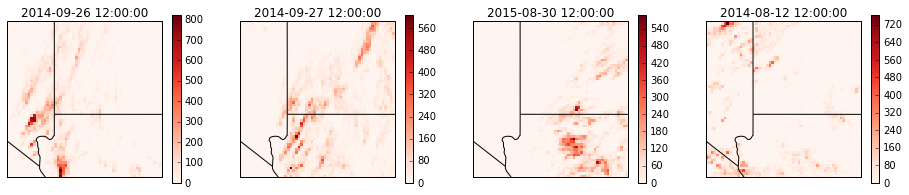

In [58]:
plt.figure(figsize=(16, 3))
for n in range(1,5):    
    ax = background(plt.subplot(1, 4, n, projection=ccrs.PlateCarree()))
    ds0 = c.get_daily_ds(top10.index[n-1],func='grid')
    ds0.close()
    den = ax.pcolor(c.gridx, c.gridy, c.FC_grid, cmap='Reds')
    ax.set_title(top10.index[n-1])
    plt.colorbar(den, ax=ax)